# Predicting Flight Delay

Problem Set-up:
We define a delayed flight to be one that is delayed by >= 15 minutes. 
The prediction problem is to train a model that can classify flights, to predict if they will or will not be delayed.

Use case:
- The idea is that this model would be useful to choosing airlines, flightpaths, airports, at the time of booking, relatively in advance of the scheduled departure (days, weeks, months ahead of time). Therefore, the prediction problem will focus on features that can be known in advance, rather than predicting using day-off features like weather and previous flights from that day. 

Notes:
- We restrict the analysis to relatively large airport, those with more than 20 (domestic) flights a day

# Create separate models to predict for each airport 

Motivation:
The weights that should eb put on features (e.g. airlines) may differ depending on the airport (see e.g. NB 4B) since different airports can have different environments (e.g. San Diego and Chicago winters are very different; American Airlines is better in Tuscon than in Anchorage.

In [1]:
# Imports
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style('white')

from sklearn.linear_model import LogisticRegression
from sklearn. metrics import roc_auc_score

# Load data

In [47]:
# Import custom code
from flightdelay.fld import io as flio
airlines_df, airports_df, flights_df = flio.load_data()

In [48]:
# Filter data to keys of interest
keys = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY']
flights_df = flights_df[keys]

# Remove airports with less than a certain number of flights

In [49]:
all_airports, airport_inverse, airport_count = np.unique(flights_df['ORIGIN_AIRPORT'],return_counts=True,return_inverse=True)

In [50]:
# Determine number of flights for the origin airport
Nflights_orig = np.zeros(len(airport_inverse))
for i in range(len(all_airports)):
    Nflights_orig[np.where(airport_inverse==i)] = airport_count[i]

In [51]:
flights_df = flights_df.loc[flights_df.index[Nflights_orig>=7300]]

# Remove cancelled flights

In [52]:
flights_df = flights_df.dropna()
flights_df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,...,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0
1,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,...,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0
2,1,1,4,US,840,N171US,SFO,CLT,20,18.0,...,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0
3,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,...,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0
4,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,...,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0


# Compute features
* one-hot day of week
* one-hot month
* one-hot airline
* one-hot airport
* one-hot departure hour

# Shuffle data

In [71]:
# Shuffle data
delay_cutoff = 15

flights_df = flights_df.reset_index(drop=True)
labels_preshuffle = flights_df['DEPARTURE_DELAY'].values > delay_cutoff

np.random.seed(0)
flight_shuff_idx = np.random.permutation(flights_df.index)
labels_shuffle = labels_preshuffle[flight_shuff_idx]

flights_df = flights_df.loc[flight_shuff_idx]

flights_df = flights_df.reset_index(drop=True)
flights_df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,HOUR_DEPARTURE
0,6,5,5,UA,1071,N61881,EWR,BQN,2059,2126.0,...,236.0,218.0,193.0,1585,59.0,5.0,55,104.0,9.0,20
1,4,5,7,B6,665,N623JB,BOS,RSW,843,1013.0,...,212.0,205.0,181.0,1249,1334.0,4.0,1215,1338.0,83.0,8
2,11,2,1,MQ,3035,N686MQ,DFW,SGF,1600,1603.0,...,79.0,69.0,56.0,364,1709.0,3.0,1719,1712.0,-7.0,16
3,12,22,2,OO,4778,N810SK,GEG,SEA,1630,1631.0,...,70.0,83.0,48.0,224,1748.0,6.0,1740,1754.0,14.0,16
4,3,27,5,US,581,N652AW,PHL,SAN,730,755.0,...,365.0,329.0,299.0,2370,1020.0,4.0,1035,1024.0,-11.0,7


### 0. Original feat

In [72]:
def make_onehot_feat_dict_from_vals(df, feat_key, feat_name, feat_cutoffs):
    
    # Create keys
    N_feat = len(feat_cutoffs) - 1
    keys = [0]*N_feat
    for i in range(N_feat):
        keys[i] = 'f_'+feat_name+'_'+ str(feat_cutoffs[i])
    # Find the indices for each class
    feat_dict = {}
    for i in range(N_feat):
        feat_dict[keys[i]] = np.transpose(
                    np.logical_and(df[feat_key].values>= feat_cutoffs[i],
                                df[feat_key].values<feat_cutoffs[i+1]))
    return feat_dict

In [73]:
cutoffs = np.arange(60,780,60)
original_feat = make_onehot_feat_dict_from_vals(flights_df,
                    'SCHEDULED_TIME', 'dur', cutoffs)

### 1. Day of week

In [74]:
def make_onehot_feat_dict(df, feat_key, feat_name):
    # Create features for each day of the week
    feat_vals = df[feat_key].values
    all_vals = np.unique(feat_vals)
    N_vals = len(all_vals)
    N_feat = N_vals - 1

    # Create keys
    keys = [0]*N_feat
    for i in range(N_feat):
        keys[i] = 'f_'+feat_name+'_'+ str(all_vals[i])

    # Create value for each training example in dict
    feat_dict = {}
    for i, k in enumerate(keys):
        this_day = all_vals[i]
        feat_dict[k] = feat_vals == this_day
    return feat_dict

In [75]:
daysfeat_dict = make_onehot_feat_dict(flights_df, 'DAY_OF_WEEK', 'day')

### 2. Month

In [76]:
monthsfeat_dict = make_onehot_feat_dict(flights_df, 'MONTH', 'month') 

### 3. Departing airport

In [77]:
dapfeat_dict = make_onehot_feat_dict(flights_df, 'ORIGIN_AIRPORT', 'dap') 

### 4. Airline

In [78]:
alfeat_dict = make_onehot_feat_dict(flights_df, 'AIRLINE', 'al') 

### 5. Departure hour

In [79]:
# Add departure hour as a feature
flights_df['HOUR_DEPARTURE'] = np.floor(flights_df['SCHEDULED_DEPARTURE'].values/100).astype(int)
hrfeat_dict = make_onehot_feat_dict(flights_df, 'HOUR_DEPARTURE', 'hr')

# Save new feature matrix

In [80]:
all_dicts = [original_feat, daysfeat_dict, monthsfeat_dict, alfeat_dict, hrfeat_dict]
feat_dict = all_dicts[0].copy()
for d in all_dicts[1:]:
    feat_dict.update(d)

In [81]:
df_feat = pd.DataFrame.from_dict(feat_dict)
df_feat.head()

,f_al_AA,f_al_AS,f_al_B6,f_al_DL,f_al_EV,f_al_F9,f_al_HA,f_al_MQ,f_al_NK,f_al_OO,...,f_month_10,f_month_11,f_month_2,f_month_3,f_month_4,f_month_5,f_month_6,f_month_7,f_month_8,f_month_9
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


# Make train val and test sets for each airport

In [82]:
airport_keys = np.array(list(dapfeat_dict.keys()))
X_train = {}
X_test = {}
y_train = {}
y_test = {}
for apk in airport_keys:
    # Isolate X and y for each airport
    ap_idx = np.transpose(np.argwhere(dapfeat_dict[apk]))[0]
    X_all = df_feat.loc[ap_idx].values
    y_all = labels_shuffle[ap_idx]
    
    # Calculate train and test set size
    N_flights = len(y_all)
    N_train = int(N_flights*.7)
    N_test = N_flights - N_train
    
    # Make train and test sets
    X_train[apk[-3:]] = X_all[:N_train]
    X_test[apk[-3:]] = X_all[N_train:]
    y_train[apk[-3:]] = y_all[:N_train]
    y_test[apk[-3:]] = y_all[N_train:]

# Train model for each airport

In [116]:
%%time
train_aucs = {}
test_aucs = {}
train_ps = {}
test_ps = {}
C = 100000
for k in X_train.keys():
    print(k)
    models = LogisticRegression(C=1)
    models.fit(X_train[k], y_train[k])
    
    # Get probabilities
    train_ps[k] = models.predict_proba(X_train[k])[:,1]
    test_ps[k] = models.predict_proba(X_test[k])[:,1]

    # Evaluate model
    train_aucs[k] = roc_auc_score(y_train[k], train_ps[k])
    test_aucs[k] = roc_auc_score(y_test[k], test_ps[k])

ABQ
ALB
ANC
ATL
AUS
BDL
BHM
BNA
BOI
BOS
BTR
BUF
BUR
BWI
CHS
CID
CLE
CLT
CMH
COS
CVG
DAL
DAY
DCA
DEN
DFW
DSM
DTW
ELP
EWR
FAT
FLL
GEG
GRR
GSO
HNL
HOU
HPN
IAD
IAH
ICT
IND
JAN
JAX
JFK
KOA
LAS
LAX
LGA
LGB
LIH
LIT
MAF
MCI
MCO
MDW
MEM
MIA
MKE
MSN
MSP
MSY
OAK
OGG
OKC
OMA
ONT
ORD
ORF
PBI
PDX
PHL
PHX
PIT
PSP
PVD
RDU
RIC
RNO
ROC
RSW
SAN
SAT
SAV
SDF
SEA
SFO
SJC
SJU
SLC
SMF
SNA
STL
TPA
TUL
TUS
TYS
CPU times: user 40.8 s, sys: 2.81 s, total: 43.6 s
Wall time: 16.2 s


(array([  0.,   0.,   3.,   4.,   8.,   9.,  13.,   6.,  16.,  14.,  10.,
          9.,   2.,   1.,   1.,   1.,   0.,   0.,   0.,   0.]),
 array([ 0.6 ,  0.61,  0.62,  0.63,  0.64,  0.65,  0.66,  0.67,  0.68,
         0.69,  0.7 ,  0.71,  0.72,  0.73,  0.74,  0.75,  0.76,  0.77,
         0.78,  0.79,  0.8 ]),
 <a list of 20 Patch objects>)

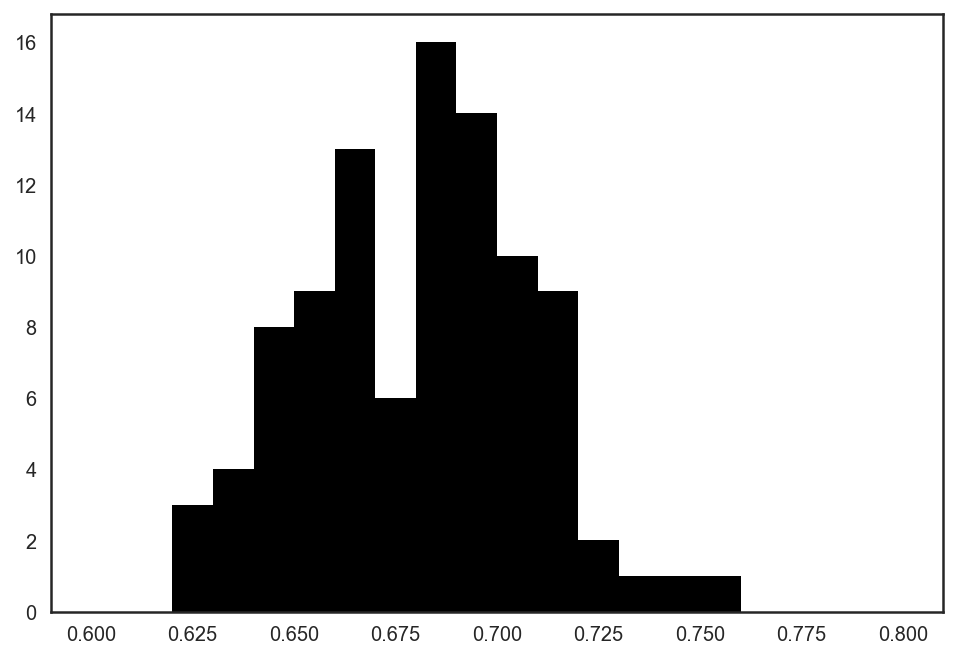

In [112]:
plt.hist(list(test_aucs.values()),bins=np.arange(0.6,0.8,0.01),color='k')

# Calculate global AUC

In [113]:
all_ps = np.hstack(list(test_ps.values()))
all_ys = np.hstack(list(y_test.values()))
print(roc_auc_score(all_ys, all_ps))

0.688510702548


In [114]:
all_ps = np.hstack(list(train_ps.values()))
all_ys = np.hstack(list(y_train.values()))
print(roc_auc_score(all_ys, all_ps))

0.691190307654


# 2. Train models with individual onehot feature sets

In [ ]:
feat_sets = [0]*len(all_dicts)
for i in range(len(all_dicts)):
    feat_sets[i] = list(all_dicts[i].keys())

In [ ]:
# Run model for all individual feature sets
models = np.zeros(len(feat_sets),dtype=object)
train_aucs = np.zeros(len(feat_sets))
test_aucs = np.zeros(len(feat_sets))
for i, ks in enumerate(feat_sets):
    print(i)
    # Train model
    models[i] = LogisticRegression(C=1)
    models[i].fit(X_train[ks], y_train)

    # Evaluate model
    train_aucs[i] = roc_auc_score(y_train, models[i].predict_proba(X_train[ks])[:,1])
    test_aucs[i] = roc_auc_score(y_test, models[i].predict_proba(X_test[ks])[:,1])

In [ ]:
print(feat_sets[0][0])
print(feat_sets[1][0])
print(feat_sets[2][0])
print(feat_sets[3][0])
print(feat_sets[4][0])
print(feat_sets[5][0])

In [ ]:
print(train_aucs)
print(test_aucs)

# 3. Train models with removing 1 feature set

In [ ]:
feat_sets = np.zeros(len(all_dicts),dtype=list)
for i in range(len(all_dicts)):
    feat_sets[i] = list(all_dicts[i].keys())

In [ ]:
# Run model for all individual feature sets
models = np.zeros(len(feat_sets),dtype=object)
train_aucs = np.zeros(len(feat_sets))
test_aucs = np.zeros(len(feat_sets))
for i, ks in enumerate(feat_sets):
    print(i)
    # Choose feats
    fis = np.delete(np.arange(len(feat_sets)),i)
    ks2 = np.hstack(feat_sets[fis])

    # Train model
    models[i] = LogisticRegression(C=1)
    models[i].fit(X_train[ks2], y_train)

    # Evaluate model
    train_aucs[i] = roc_auc_score(y_train, models[i].predict_proba(X_train[ks2])[:,1])
    test_aucs[i] = roc_auc_score(y_test, models[i].predict_proba(X_test[ks2])[:,1])

In [ ]:
print(train_aucs)
print(test_aucs)